<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_TL4_Outros_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Transfer Learning Teste de Modelos

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns

import re

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomHeight, RandomRotation, RandomWidth, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, InceptionV3, ResNet50V2

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

## Constantes

In [3]:
SEMENTE = 2008193

DIR_TREINO = '10_food_classes_all_data/train'
DIR_TESTE  = '10_food_classes_all_data/test'

TAMANHO_LOTE = 32
FORMATO_IMAGEM = (224, 224)
MODO_CLASSE = 'categorical'

FORMATO_ENTRADA = FORMATO_IMAGEM + (3,)
ATIVACAO = 'softmax'

PERDA = 'categorical_crossentropy'
METRICAS = ['accuracy']

# OTIMIZADOR = 'Adam'
APRENDIZADO = 0.001

ITERACOES = 5

### Modelos

In [4]:
# MODELOS_BASE = [EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, InceptionV3, ResNet50V2]
MODELOS_BASE = []

# MODELOS_HUB = ['https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1',
#                'https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1',
#                'https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1',
#                'https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1',
#                'https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5',
#                'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5',
#                'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5']
MODELOS_HUB = []

# Modelos testados e descartados:
# Com performance muito inferior: ResNet50, VGG16
# Com performance levemente inferior:
# EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
# EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
# https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1
# https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1
# https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1
# https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1

## Funções

In [5]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-26 14:42:35--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196 (5.1K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   5.07K  --.-KB/s    in 0s      

2023-01-26 14:42:35 (67.2 MB/s) - ‘funcoes.py’ saved [5196/5196]



In [6]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, unzip_data

## Dados

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2023-01-26 14:42:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  22.2MB/s    in 23s     

2023-01-26 14:42:59 (21.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



### Importando os dados e tranformando-os em lotes

In [8]:
dados_treino = image_dataset_from_directory(directory=DIR_TREINO,
                                            batch_size=TAMANHO_LOTE,
                                            image_size=FORMATO_IMAGEM,
                                            label_mode=MODO_CLASSE,
                                            seed=SEMENTE)

dados_teste = image_dataset_from_directory(directory=DIR_TESTE,
                                           batch_size=TAMANHO_LOTE,
                                           image_size=FORMATO_IMAGEM,
                                           label_mode=MODO_CLASSE,
                                           shuffle=False, # Não embaralhar os dados de teste para permitir avaliarmos as previsões.
                                           seed=SEMENTE)

rotulos = dados_treino.class_names

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Modelos

In [9]:
modelos = {}

16705208/16705208 [==============================] - 2s 0us/step
Salvando log TensorBoard em: 'outros_modelos/modelo_base_efficientnetb0/20230126-144313'.
Epoch 1/5
235/235 [==============================] - 106s 399ms/step - loss: 1.0165 - accuracy: 0.7013 - val_loss: 0.5746 - val_accuracy: 0.8420
Epoch 2/5
235/235 [==============================] - 67s 285ms/step - loss: 0.6341 - accuracy: 0.8071 - val_loss: 0.4835 - val_accuracy: 0.8612
Epoch 3/5
235/235 [==============================] - 63s 268ms/step - loss: 0.5543 - accuracy: 0.8268 - val_loss: 0.4391 - val_accuracy: 0.8680
Epoch 4/5
235/235 [==============================] - 58s 247ms/step - loss: 0.5093 - accuracy: 0.8421 - val_loss: 0.4207 - val_accuracy: 0.8740
Epoch 5/5
235/235 [==============================] - 56s 237ms/step - loss: 0.4764 - accuracy: 0.8497 - val_loss: 0.4109 - val_accuracy: 0.8728


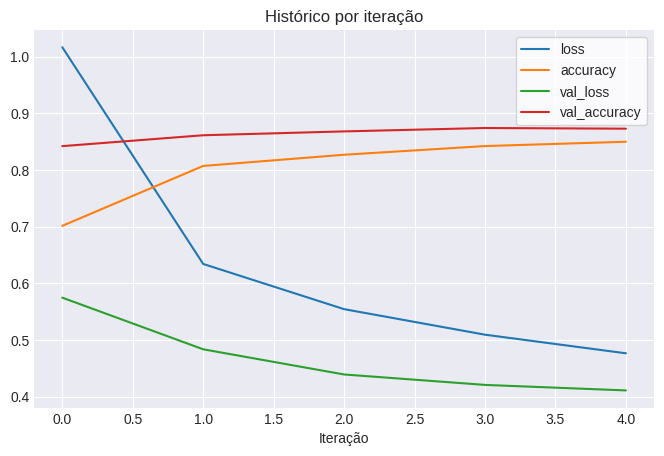

27018416/27018416 [==============================] - 2s 0us/step
Salvando log TensorBoard em: 'outros_modelos/modelo_base_efficientnetb1/20230126-144911'.
Epoch 1/5
235/235 [==============================] - 77s 292ms/step - loss: 1.0311 - accuracy: 0.6884 - val_loss: 0.6064 - val_accuracy: 0.8224
Epoch 2/5
235/235 [==============================] - 60s 253ms/step - loss: 0.6404 - accuracy: 0.8021 - val_loss: 0.5059 - val_accuracy: 0.8480
Epoch 3/5
235/235 [==============================] - 59s 251ms/step - loss: 0.5676 - accuracy: 0.8213 - val_loss: 0.4706 - val_accuracy: 0.8492
Epoch 4/5
235/235 [==============================] - 57s 241ms/step - loss: 0.5168 - accuracy: 0.8356 - val_loss: 0.4502 - val_accuracy: 0.8612
Epoch 5/5
235/235 [==============================] - 54s 228ms/step - loss: 0.4888 - accuracy: 0.8459 - val_loss: 0.4370 - val_accuracy: 0.8532


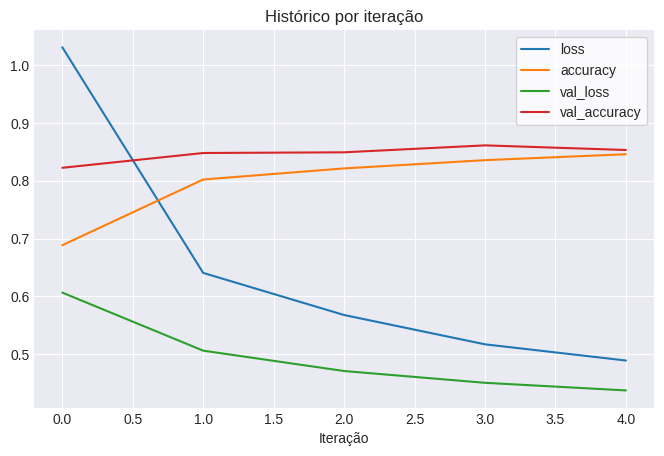

31790344/31790344 [==============================] - 3s 0us/step
Salvando log TensorBoard em: 'outros_modelos/modelo_base_efficientnetb2/20230126-145450'.
Epoch 1/5
235/235 [==============================] - 76s 288ms/step - loss: 0.9879 - accuracy: 0.7153 - val_loss: 0.5621 - val_accuracy: 0.8360
Epoch 2/5
235/235 [==============================] - 53s 225ms/step - loss: 0.6180 - accuracy: 0.8120 - val_loss: 0.4963 - val_accuracy: 0.8500
Epoch 3/5
235/235 [==============================] - 52s 219ms/step - loss: 0.5522 - accuracy: 0.8263 - val_loss: 0.4484 - val_accuracy: 0.8512
Epoch 4/5
235/235 [==============================] - 50s 212ms/step - loss: 0.5119 - accuracy: 0.8356 - val_loss: 0.4322 - val_accuracy: 0.8548
Epoch 5/5
235/235 [==============================] - 49s 206ms/step - loss: 0.4904 - accuracy: 0.8424 - val_loss: 0.4211 - val_accuracy: 0.8668


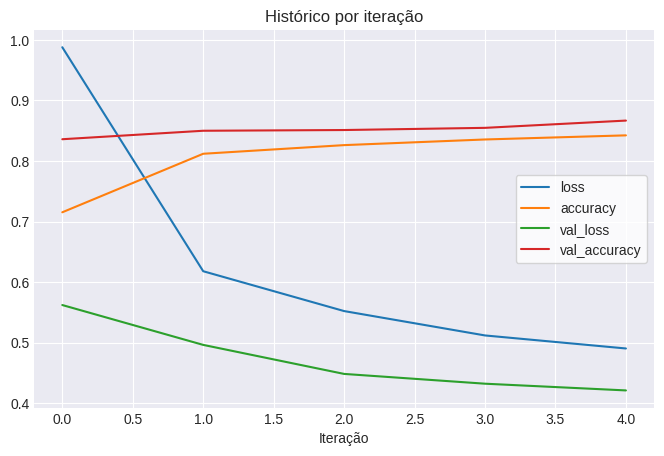

43941136/43941136 [==============================] - 3s 0us/step
Salvando log TensorBoard em: 'outros_modelos/modelo_base_efficientnetb3/20230126-145951'.
Epoch 1/5
235/235 [==============================] - 158s 633ms/step - loss: 0.9605 - accuracy: 0.7187 - val_loss: 0.5547 - val_accuracy: 0.8364
Epoch 2/5
235/235 [==============================] - 119s 505ms/step - loss: 0.6020 - accuracy: 0.8143 - val_loss: 0.4902 - val_accuracy: 0.8512
Epoch 3/5
235/235 [==============================] - 102s 434ms/step - loss: 0.5400 - accuracy: 0.8305 - val_loss: 0.4622 - val_accuracy: 0.8544
Epoch 4/5
235/235 [==============================] - 93s 395ms/step - loss: 0.5046 - accuracy: 0.8379 - val_loss: 0.4231 - val_accuracy: 0.8652
Epoch 5/5
235/235 [==============================] - 92s 390ms/step - loss: 0.4781 - accuracy: 0.8483 - val_loss: 0.4198 - val_accuracy: 0.8644


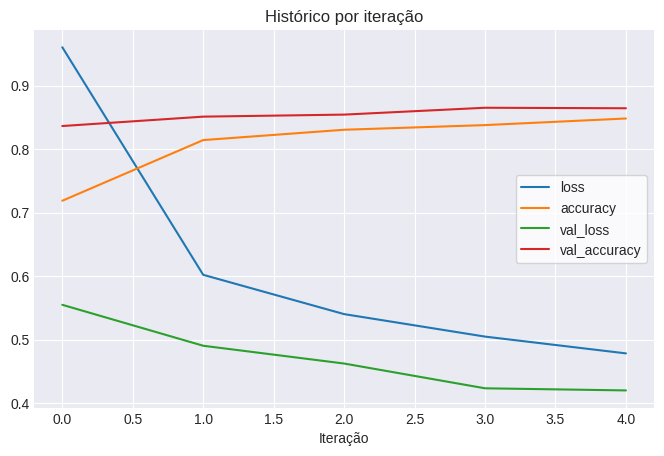

87910968/87910968 [==============================] - 5s 0us/step
Salvando log TensorBoard em: 'outros_modelos/modelo_base_inception_v3/20230126-151039'.
Epoch 1/5
235/235 [==============================] - 171s 705ms/step - loss: 1.2051 - accuracy: 0.6115 - val_loss: 0.8780 - val_accuracy: 0.7064
Epoch 2/5
235/235 [==============================] - 106s 451ms/step - loss: 0.9220 - accuracy: 0.7045 - val_loss: 0.7404 - val_accuracy: 0.7568
Epoch 3/5
235/235 [==============================] - 89s 377ms/step - loss: 0.8657 - accuracy: 0.7192 - val_loss: 0.7138 - val_accuracy: 0.7732
Epoch 4/5
235/235 [==============================] - 80s 341ms/step - loss: 0.8289 - accuracy: 0.7393 - val_loss: 0.7072 - val_accuracy: 0.7784
Epoch 5/5
235/235 [==============================] - 72s 306ms/step - loss: 0.7736 - accuracy: 0.7479 - val_loss: 0.6765 - val_accuracy: 0.7852


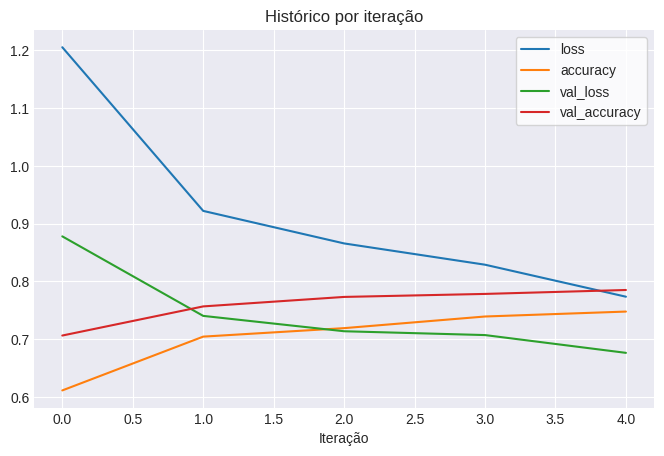

94668760/94668760 [==============================] - 5s 0us/step
Salvando log TensorBoard em: 'outros_modelos/modelo_base_resnet50v2/20230126-151938'.
Epoch 1/5
235/235 [==============================] - 167s 691ms/step - loss: 1.2132 - accuracy: 0.6051 - val_loss: 0.7921 - val_accuracy: 0.7364
Epoch 2/5
235/235 [==============================] - 98s 416ms/step - loss: 0.8653 - accuracy: 0.7209 - val_loss: 0.7412 - val_accuracy: 0.7436
Epoch 3/5
235/235 [==============================] - 79s 336ms/step - loss: 0.8036 - accuracy: 0.7375 - val_loss: 0.6957 - val_accuracy: 0.7688
Epoch 4/5
235/235 [==============================] - 68s 289ms/step - loss: 0.7560 - accuracy: 0.7568 - val_loss: 0.6731 - val_accuracy: 0.7700
Epoch 5/5
235/235 [==============================] - 63s 267ms/step - loss: 0.7164 - accuracy: 0.7648 - val_loss: 0.6478 - val_accuracy: 0.7888


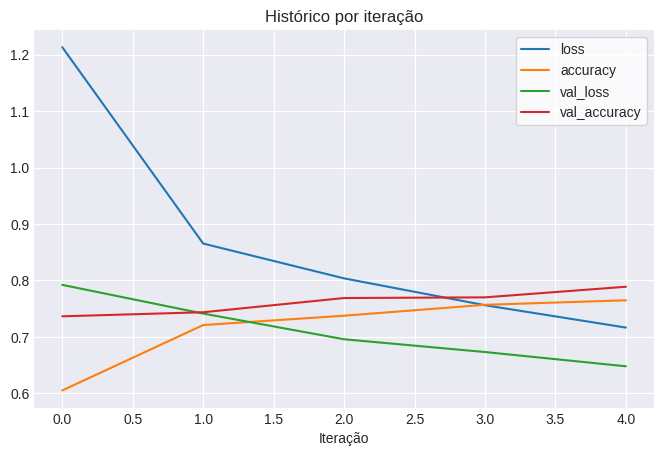

Salvando log TensorBoard em: 'outros_modelos/modelo_hub_tensorflow_efficientnet_b0_feature_vector_1/20230126-152908'.
Epoch 1/5
235/235 [==============================] - 52s 178ms/step - loss: 1.0764 - accuracy: 0.6852 - val_loss: 0.4686 - val_accuracy: 0.8728
Epoch 2/5
235/235 [==============================] - 37s 155ms/step - loss: 0.6768 - accuracy: 0.7945 - val_loss: 0.3921 - val_accuracy: 0.8848
Epoch 3/5
235/235 [==============================] - 35s 149ms/step - loss: 0.6061 - accuracy: 0.8099 - val_loss: 0.3538 - val_accuracy: 0.8932
Epoch 4/5
235/235 [==============================] - 35s 149ms/step - loss: 0.5621 - accuracy: 0.8221 - val_loss: 0.3309 - val_accuracy: 0.8992
Epoch 5/5
235/235 [==============================] - 35s 148ms/step - loss: 0.5309 - accuracy: 0.8340 - val_loss: 0.3239 - val_accuracy: 0.9020


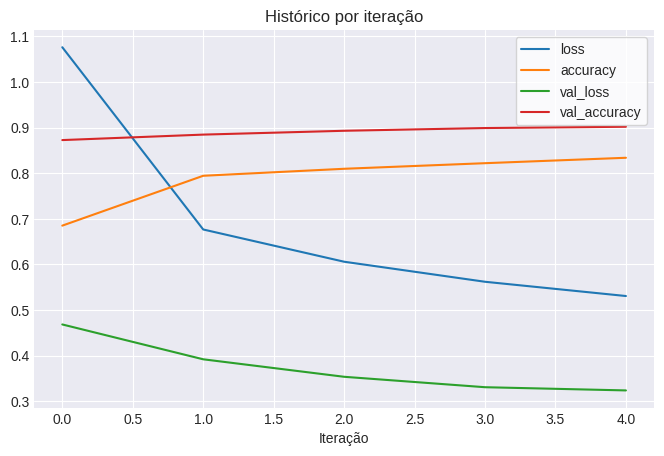

Salvando log TensorBoard em: 'outros_modelos/modelo_hub_tensorflow_efficientnet_b1_feature_vector_1/20230126-153323'.
Epoch 1/5
235/235 [==============================] - 59s 198ms/step - loss: 1.0673 - accuracy: 0.6883 - val_loss: 0.4715 - val_accuracy: 0.8540
Epoch 2/5
235/235 [==============================] - 42s 179ms/step - loss: 0.6768 - accuracy: 0.7895 - val_loss: 0.3715 - val_accuracy: 0.8844
Epoch 3/5
235/235 [==============================] - 42s 179ms/step - loss: 0.5980 - accuracy: 0.8124 - val_loss: 0.3519 - val_accuracy: 0.8896
Epoch 4/5
235/235 [==============================] - 44s 184ms/step - loss: 0.5608 - accuracy: 0.8224 - val_loss: 0.3293 - val_accuracy: 0.8952
Epoch 5/5
235/235 [==============================] - 42s 178ms/step - loss: 0.5310 - accuracy: 0.8312 - val_loss: 0.3186 - val_accuracy: 0.8964


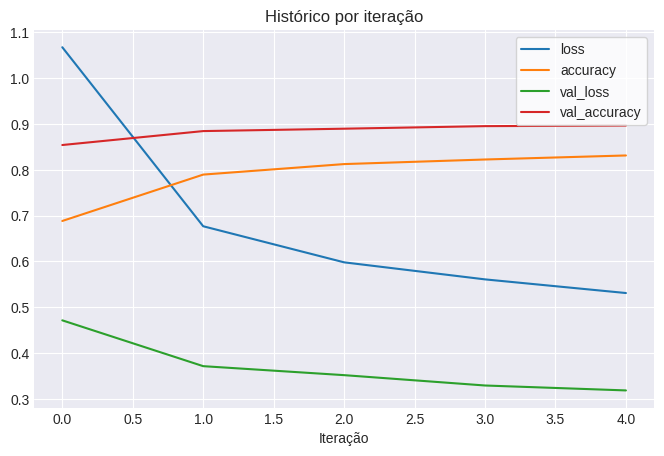

Salvando log TensorBoard em: 'outros_modelos/modelo_hub_tensorflow_efficientnet_b2_feature_vector_1/20230126-154001'.
Epoch 1/5
235/235 [==============================] - 64s 214ms/step - loss: 1.0515 - accuracy: 0.6903 - val_loss: 0.4519 - val_accuracy: 0.8652
Epoch 2/5
235/235 [==============================] - 43s 182ms/step - loss: 0.6483 - accuracy: 0.7995 - val_loss: 0.3641 - val_accuracy: 0.8876
Epoch 3/5
235/235 [==============================] - 44s 183ms/step - loss: 0.5813 - accuracy: 0.8187 - val_loss: 0.3330 - val_accuracy: 0.8924
Epoch 4/5
235/235 [==============================] - 43s 182ms/step - loss: 0.5436 - accuracy: 0.8279 - val_loss: 0.3180 - val_accuracy: 0.8988
Epoch 5/5
235/235 [==============================] - 43s 179ms/step - loss: 0.5093 - accuracy: 0.8339 - val_loss: 0.3144 - val_accuracy: 0.8988


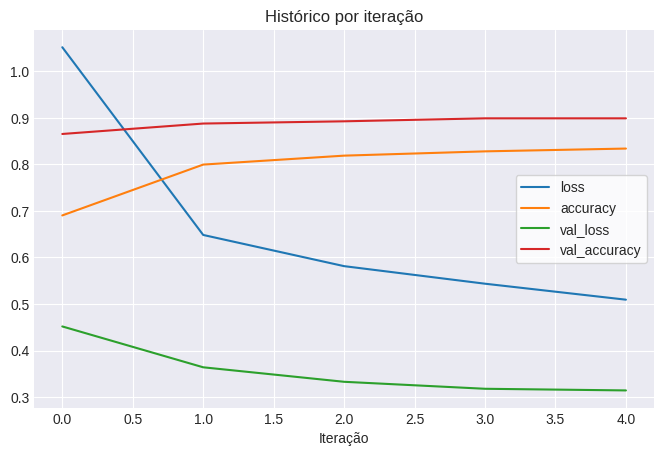

Salvando log TensorBoard em: 'outros_modelos/modelo_hub_tensorflow_efficientnet_b3_feature_vector_1/20230126-154454'.
Epoch 1/5
235/235 [==============================] - 95s 337ms/step - loss: 0.9909 - accuracy: 0.7120 - val_loss: 0.4316 - val_accuracy: 0.8684
Epoch 2/5
235/235 [==============================] - 68s 287ms/step - loss: 0.6364 - accuracy: 0.7997 - val_loss: 0.3691 - val_accuracy: 0.8808
Epoch 3/5
235/235 [==============================] - 67s 283ms/step - loss: 0.5755 - accuracy: 0.8116 - val_loss: 0.3365 - val_accuracy: 0.8888
Epoch 4/5
235/235 [==============================] - 69s 291ms/step - loss: 0.5381 - accuracy: 0.8265 - val_loss: 0.3255 - val_accuracy: 0.8928
Epoch 5/5
235/235 [==============================] - 64s 272ms/step - loss: 0.5190 - accuracy: 0.8320 - val_loss: 0.3114 - val_accuracy: 0.9016


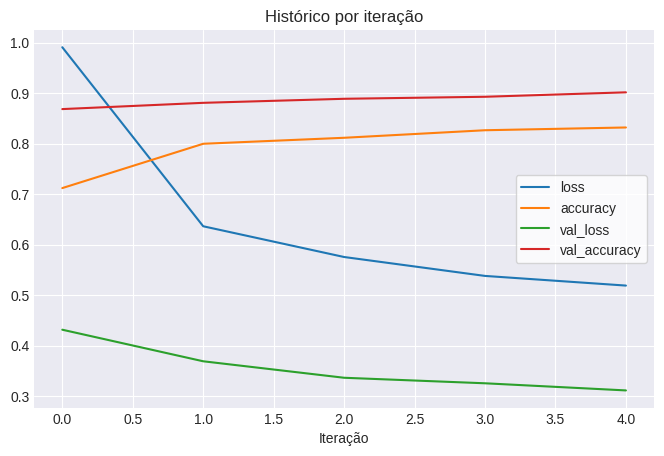

Salvando log TensorBoard em: 'outros_modelos/modelo_hub_google_imagenet_resnet_v1_50_feature_vector_5/20230126-155107'.
Epoch 1/5
235/235 [==============================] - 75s 298ms/step - loss: 1.1381 - accuracy: 0.6352 - val_loss: 0.6933 - val_accuracy: 0.7684
Epoch 2/5
235/235 [==============================] - 58s 243ms/step - loss: 0.7991 - accuracy: 0.7425 - val_loss: 0.5486 - val_accuracy: 0.8208
Epoch 3/5
235/235 [==============================] - 53s 225ms/step - loss: 0.7202 - accuracy: 0.7648 - val_loss: 0.5776 - val_accuracy: 0.8008
Epoch 4/5
235/235 [==============================] - 51s 215ms/step - loss: 0.6693 - accuracy: 0.7840 - val_loss: 0.4986 - val_accuracy: 0.8352
Epoch 5/5
235/235 [==============================] - 48s 204ms/step - loss: 0.6335 - accuracy: 0.7919 - val_loss: 0.4888 - val_accuracy: 0.8372


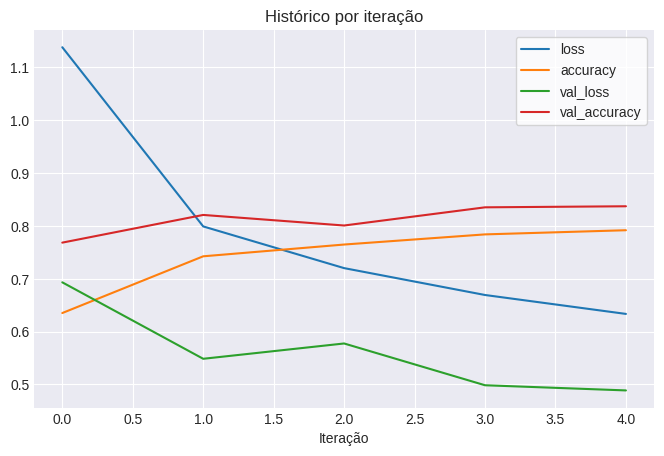

Salvando log TensorBoard em: 'outros_modelos/modelo_hub_google_imagenet_resnet_v2_50_feature_vector_5/20230126-155738'.
Epoch 1/5
235/235 [==============================] - 56s 219ms/step - loss: 1.1717 - accuracy: 0.6173 - val_loss: 0.5757 - val_accuracy: 0.8060
Epoch 2/5
235/235 [==============================] - 51s 215ms/step - loss: 0.8328 - accuracy: 0.7309 - val_loss: 0.5231 - val_accuracy: 0.8164
Epoch 3/5
235/235 [==============================] - 49s 206ms/step - loss: 0.7501 - accuracy: 0.7561 - val_loss: 0.4978 - val_accuracy: 0.8296
Epoch 4/5
235/235 [==============================] - 49s 205ms/step - loss: 0.7178 - accuracy: 0.7681 - val_loss: 0.5070 - val_accuracy: 0.8236
Epoch 5/5
235/235 [==============================] - 47s 200ms/step - loss: 0.6731 - accuracy: 0.7795 - val_loss: 0.5047 - val_accuracy: 0.8292


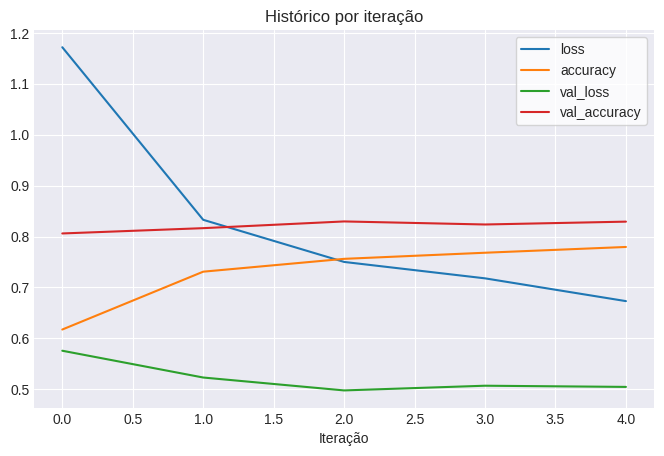

Salvando log TensorBoard em: 'outros_modelos/modelo_hub_google_imagenet_inception_v3_feature_vector_5/20230126-160304'.
Epoch 1/5
235/235 [==============================] - 60s 231ms/step - loss: 1.1877 - accuracy: 0.6155 - val_loss: 0.6562 - val_accuracy: 0.7720
Epoch 2/5
235/235 [==============================] - 54s 229ms/step - loss: 0.8714 - accuracy: 0.7172 - val_loss: 0.5359 - val_accuracy: 0.8160
Epoch 3/5
235/235 [==============================] - 54s 230ms/step - loss: 0.8096 - accuracy: 0.7427 - val_loss: 0.5485 - val_accuracy: 0.8124
Epoch 4/5
235/235 [==============================] - 51s 217ms/step - loss: 0.7796 - accuracy: 0.7441 - val_loss: 0.5248 - val_accuracy: 0.8136
Epoch 5/5
235/235 [==============================] - 48s 204ms/step - loss: 0.7550 - accuracy: 0.7457 - val_loss: 0.6477 - val_accuracy: 0.7808


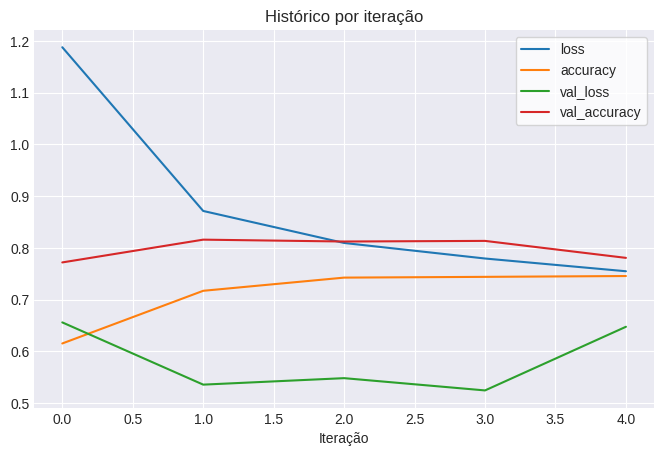

In [10]:
for mb in MODELOS_BASE:
    modelo_base = mb(include_top=False)
    modelo_base.trainable = False

    modelo_nome = f'modelo_base_{modelo_base.name}'

    entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

    expansao_dados = Sequential(name='expansao_dados')

    if modelo_base.name[:12] != 'efficientnet':
        expansao_dados.add(Rescaling(1./255))

    expansao_dados.add(RandomFlip('horizontal'))
    expansao_dados.add(RandomHeight(0.2))
    expansao_dados.add(RandomRotation(0.2))
    expansao_dados.add(RandomWidth(0.2))
    expansao_dados.add(RandomZoom(0.2))

    # Há um bug na versão 2.8 do TensorFlow que faz necessário forçar o treinamento para que a expansão dos dados funcione.
    expandidos = expansao_dados(entradas, training=True)

    camadas = modelo_base(expandidos, training=False)
    camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

    saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

    modelo = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

    modelo.compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)
    
    historico = modelo.fit(dados_treino,
                           epochs=ITERACOES,
                           steps_per_epoch=len(dados_treino),
                           validation_data=dados_teste,
                           validation_steps=len(dados_teste),
                           callbacks=[criar_callback_tensorboard(diretorio='outros_modelos', experimento=modelo_nome)],
                           verbose=1)

    modelos[modelo_nome] = modelo
    
    grafico_historico_por_iteracao(historico)


for mh in MODELOS_HUB:
    modelo_nome = "modelo_hub_" + re.sub('\W+', '_', mh[18:])
    
    modelo = Sequential(name=modelo_nome)

    modelo.add(Rescaling(1./255))
    modelo.add(RandomFlip('horizontal'))
    modelo.add(RandomHeight(0.2))
    modelo.add(RandomRotation(0.2))
    modelo.add(RandomWidth(0.2))
    modelo.add(RandomZoom(0.2))

    modelo.add(hub.KerasLayer(handle=mh,
                              trainable=False,
                              input_shape=FORMATO_ENTRADA))

    modelo.add(Dense(len(rotulos), activation=ATIVACAO))

    modelo.compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)
    
    historico = modelo.fit(dados_treino,
                           epochs=ITERACOES,
                           steps_per_epoch=len(dados_treino),
                           validation_data=dados_teste,
                           validation_steps=len(dados_teste),
                           callbacks=[criar_callback_tensorboard(diretorio='outros_modelos', experimento=modelo_nome)],
                           verbose=1)

    modelos[modelo_nome] = modelo
    
    grafico_historico_por_iteracao(historico)


## Salvando modelos

In [13]:
# for modelo_nome, modelo in modelos.items():
#     modelo.save(f'{modelo_nome}_HDF5.h5')

## Comparando modelos utilizando TensorBoard

In [ ]:
# !tensorboard dev upload --logdir ./outros_modelos/ \
#                         --name "Teste de Modelos." \
#                         --description "Teste de modelos EfficientNet, Inception, ResNet. Base de dados Food101 reduzida." \
#                         --one_shot

TensorBoard link: https://tensorboard.dev/experiment/R9Z08gZ4QuygfAaHbu4EhQ/

In [16]:
# # Apagar diretórios não-vazios
# import shutil
# shutil.rmtree('outros_modelos')